# Massachusetts Education Data
    By: Andrew Ellis

In [20]:
!pip install -U pandasql;
!pip install --upgrade pip

Requirement already up-to-date: pandasql in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (from pandasql)
Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (from pandasql)
Requirement already up-to-date: sqlalchemy in /opt/conda/lib/python3.6/site-packages (from pandasql)
Requirement already up-to-date: python-dateutil>=2 in /opt/conda/lib/python3.6/site-packages (from pandas->pandasql)
Requirement already up-to-date: pytz>=2011k in /opt/conda/lib/python3.6/site-packages (from pandas->pandasql)
Requirement already up-to-date: six>=1.5 in /opt/conda/lib/python3.6/site-packages (from python-dateutil>=2->pandas->pandasql)
Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import DBSCAN
from pandasql import sqldf

from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()

%matplotlib inline

# Notes for capstone:

    - I should use a clustering model at some point. 
    - I am going to use bagging as well.
    - Do I want to do classification? try something like (train['Percent_Change]>0).astype(int)

# EDA Section:
    - Dropping columns.
    - Merging necessary data.
    - Selecting the target variable (It is actually pretty hard).

In [22]:
df= pd.read_csv('MA_Public_Schools_2017.csv')
df.shape

(1861, 302)

In [23]:
df.head()

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0


In [24]:
 q = """
SELECT Town
FROM df
WHERE Town is 'Somerville'
LIMIT(3)
 """

sqldf(q, locals())

,Town
0,Somerville
1,Somerville
2,Somerville


In [25]:
df_nulls = df.isnull().sum()
df_nulls = df_nulls.sort_values(ascending=False)
df_nulls
#Given the amount of nulls in a lot of these columns, I am going to 
#drop any that are over 80% null.

MCAS_3rdGrade_English_SGP                1861
MCAS_3rdGrade_Math_SGP                   1861
MCAS_3rdGrade_Math_Incl. in SGP(#)       1861
MCAS_3rdGrade_English_Incl. in SGP(#)    1861
Address 2                                1831
MCAS_8thGrade_English_SGP                1734
MCAS_8thGrade_Math_SGP                   1734
MCAS_7thGrade_Math_SGP                   1733
MCAS_7thGrade_English_SGP                1733
% MCAS_7thGrade_English_W/F              1732
% MCAS_7thGrade_English_P+A              1732
MCAS_7thGrade_English_Stud. Incl. #      1732
MCAS_7thGrade_English_W/F #              1732
% MCAS_7thGrade_English_NI               1732
MCAS_7thGrade_English_NI #               1732
% MCAS_7thGrade_English_P                1732
MCAS_7thGrade_English_P #                1732
% MCAS_7thGrade_English_A                1732
MCAS_7thGrade_English_A #                1732
MCAS_7thGrade_English_P+A #              1732
% MCAS_7thGrade_Math_P                   1732
MCAS_7thGrade_Math_NI #           

In [30]:
#I am going to drop the 4 columns that are all nulls (see top of df_nulls)

#df = df.drop(['MCAS_3rdGrade_English_SGP', 'MCAS_3rdGrade_Math_SGP', 
#              'MCAS_3rdGrade_Math_Incl. in SGP(#)', 'MCAS_3rdGrade_English_Incl. in SGP(#)', 
#              'Function', 'Contact Name', 'Fax', 'Phone', 'Address 2', 'Address 1'], axis = 1)

In [31]:
df.shape

(1861, 292)

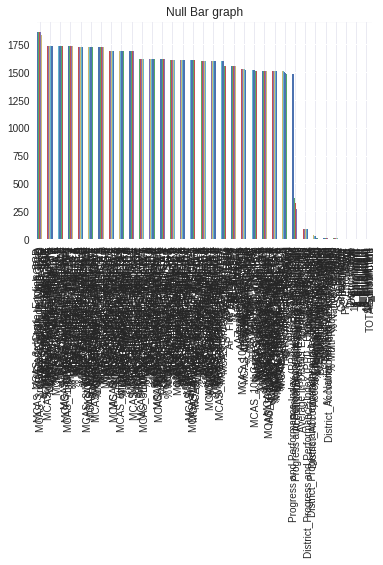

In [32]:
df_nulls.plot(kind='bar', title='Null Bar graph')

In [14]:
df.shape

(1861, 298)

In [33]:
df.head(3)

,School Code,School Name,School Type,Town,State,Zip,Grade,District Name,District Code,PK_Enrollment,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Abington,MA,2351,"09,10,11,12",Abington,10000,0,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Abington,MA,2351,"01,02,03,04",Abington,10000,0,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Abington,MA,2351,"PK,K",Abington,10000,69,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0


In [34]:
df['State'].nunique()

1

In [46]:
#df.drop(['State'], axis = 1, inplace=True)
df.shape

(1861, 291)

Now I want to see if I need to drop any rows

In [48]:
transposed = df.set_index('School Code').T
transposed.head()
transposed.isnull().sum();
#Do I want to drop rows though??

How can we fill certain nulls?

In [51]:
df.select_dtypes(include=object)
#I see that 'Accountability and Assistance description are both here... I might drop the 'description'
#column because I want to make the objects more measurable.
#Accountability levels indicate whether a school is meeting their 'close the gap' expectations
#What does it take to

,School Name,School Type,Town,Grade,District Name,AP_Test Takers,AP_Tests Taken,Accountability and Assistance Level,Accountability and Assistance Description,District_Accountability and Assistance Level,District_Accountability and Assistance Description
0,Abington High,Public School,Abington,"09,10,11,12",Abington,70,123,Level 1,Meeting gap narrowing goals,Level 3,One or more schools in the district classified...
1,Beaver Brook Elementary School,Public School,Abington,"01,02,03,04",Abington,NaN,NaN,Level 3,Among lowest performing 20% of subgroups,Level 3,One or more schools in the district classified...
2,Center Elementary School,Public School,Abington,"PK,K",Abington,NaN,NaN,Insufficient data,NaN,Level 3,One or more schools in the district classified...
3,Frolio Middle School,Public School,Abington,"07,08",Abington,NaN,NaN,Level 2,Not meeting gap narrowing goals,Level 3,One or more schools in the district classified...
4,Woodsdale Elementary School,Public School,Abington,"05,06",Abington,NaN,NaN,Level 2,Not meeting gap narrowing goals,Level 3,One or more schools in the district classified...
5,Acushnet Elementary School,Public School,Acushnet,"PK,K,01,02,03,04",Acushnet,NaN,NaN,Level 2,Not meeting gap narrowing goals,Level 2,One or more schools in the district classified...
6,Albert F Ford Middle School,Public School,Acushnet,"05,06,07,08",Acushnet,NaN,NaN,Level 2,Not meeting gap narrowing goals,Level 2,One or more schools in the district classified...
7,Agawam Early Childhood Center,Public School,Agawam,PK,Agawam,NaN,NaN,Insufficient data,NaN,Level 2,One or more schools in the district classified...
8,Agawam High,Public School,Agawam,"09,10,11,12",Agawam,242,452,Level 2,Not meeting gap narrowing goals,Level 2,One or more schools in the district classified...
9,Agawam Junior High,Public School,Feeding Hills,"07,08",Agawam,NaN,NaN,Level 2,Not meeting gap narrowing goals,Level 2,One or more schools in the district classified...


In [81]:
#df.drop('Accountability and Assistance Description', axis=1, inplace = True)
#Takes care of one object column...
df['AP_Test Takers'].fillna(value=0, inplace=True)

In [75]:
df['AP_Tests Taken'].fillna(value=0, inplace=True)
df['AP_Tests Taken'].dtype

dtype('O')

# Creating High School, Middle School, and Elementary School df's:

In [84]:
df_high=df.loc[(df['10_Enrollment'] != 0)]
df_high.shape

(395, 290)

In [86]:
df_middle=df.loc[(df['7_Enrollment'] !=0) & (df['2_Enrollment'] ==0)]
df_middle.shape

(373, 290)

In [88]:
df_k8 = df.loc[(df['K_Enrollment'] !=0) & (df['8_Enrollment'] !=0)]
df_k8.shape

(117, 290)

In [89]:
df_elem = df.loc[(df['2_Enrollment'] !=0)]
df_elem.shape

(983, 290)

# df_elem workspace:

In [91]:
df_elem.head()

,School Code,School Name,School Type,Town,Zip,Grade,District Name,District Code,PK_Enrollment,K_Enrollment,...,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
1,10003,Beaver Brook Elementary School,Public School,Abington,2351,"01,02,03,04",Abington,10000,0,0,...,NaN,NaN,Level 3,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
5,30025,Acushnet Elementary School,Public School,Acushnet,2743,"PK,K,01,02,03,04",Acushnet,30000,50,84,...,NaN,NaN,Level 2,65.0,74.0,68.0,Level 2,One or more schools in the district classified...,50.0,57.0
10,50020,Benjamin J Phelps,Public School,Agawam,1001,"K,01,02,03,04",Agawam,50000,0,91,...,NaN,NaN,Level 2,28.0,52.0,55.0,Level 2,One or more schools in the district classified...,54.0,56.0
11,50010,Clifford M Granger,Public School,Feeding Hills,1030,"K,01,02,03,04",Agawam,50000,0,60,...,NaN,NaN,Level 2,68.0,77.0,53.0,Level 2,One or more schools in the district classified...,54.0,56.0
12,50030,James Clark School,Public School,Agawam,1001,"K,01,02,03,04",Agawam,50000,0,67,...,NaN,NaN,Level 2,46.0,64.0,59.0,Level 2,One or more schools in the district classified...,54.0,56.0


# df_middle workspace:

In [92]:
df_middle.head()

,School Code,School Name,School Type,Town,Zip,Grade,District Name,District Code,PK_Enrollment,K_Enrollment,...,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
3,10405,Frolio Middle School,Public School,Abington,2351,"07,08",Abington,10000,0,0,...,NaN,NaN,Level 2,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
6,30305,Albert F Ford Middle School,Public School,Acushnet,2743,"05,06,07,08",Acushnet,30000,0,0,...,NaN,NaN,Level 2,53.0,52.0,52.0,Level 2,One or more schools in the district classified...,50.0,57.0
9,50405,Agawam Junior High,Public School,Feeding Hills,1030,"07,08",Agawam,50000,0,0,...,NaN,NaN,Level 2,30.0,54.0,54.0,Level 2,One or more schools in the district classified...,54.0,56.0
13,50303,Roberta G. Doering School,Public School,Agawam,1001,"05,06,07,08",Agawam,50000,0,0,...,NaN,NaN,Level 2,54.0,52.0,52.0,Level 2,One or more schools in the district classified...,54.0,56.0
18,70013,Amesbury Middle,Public School,Amesbury,1913,"05,06,07,08",Amesbury,70000,0,0,...,NaN,NaN,Level 2,50.0,50.0,46.0,Level 2,One or more schools in the district classified...,50.0,46.0


# df_k8 workspace:

In [93]:
df_k8.head()

,School Code,School Name,School Type,Town,Zip,Grade,District Name,District Code,PK_Enrollment,K_Enrollment,...,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
126,350012,Boston Teachers Union School,Public School,Jamaica Plain,2130,"PK,K,01,02,03,04,05,06,07,08",Boston,350000,21,21,...,NaN,NaN,Level 2,25.0,81.0,82.0,Level 4,One or more schools in the district classified...,53.0,54.0
135,350020,Curley K-8 School,Public School,Jamaica Plain,2130,"PK,K,01,02,03,04,05,06,07,08",Boston,350000,106,89,...,NaN,NaN,Level 3,21.0,47.0,40.0,Level 4,One or more schools in the district classified...,53.0,54.0
140,350077,Dennis C Haley,Public School,Roslindale,2131,"PK,K,01,02,03,04,05,06,07,08",Boston,350000,25,38,...,NaN,NaN,Level 3,31.0,69.0,69.0,Level 4,One or more schools in the district classified...,53.0,54.0
141,350080,Donald Mckay,Public School,East Boston,2128,"PK,K,01,02,03,04,05,06,07,08",Boston,350000,19,59,...,NaN,NaN,Level 1,30.0,84.0,86.0,Level 4,One or more schools in the district classified...,53.0,54.0
149,350375,Edison K-8,Public School,Brighton,2135,"PK,K,01,02,03,04,05,06,07,08",Boston,350000,20,53,...,NaN,NaN,Level 3,18.0,50.0,45.0,Level 4,One or more schools in the district classified...,53.0,54.0


# df_high workspace:

In [94]:
df_high.head()

,School Code,School Name,School Type,Town,Zip,Grade,District Name,District Code,PK_Enrollment,K_Enrollment,...,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Abington,2351,"09,10,11,12",Abington,10000,0,0,...,56.0,111.0,Level 1,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
8,50505,Agawam High,Public School,Agawam,1001,"09,10,11,12",Agawam,50000,0,0,...,51.0,263.0,Level 2,41.0,65.0,61.0,Level 2,One or more schools in the district classified...,54.0,56.0
16,70505,Amesbury High,Public School,Amesbury,1913,"09,10,11,12",Amesbury,70000,0,0,...,41.0,133.0,Level 2,53.0,67.0,66.0,Level 2,One or more schools in the district classified...,50.0,46.0
17,70515,Amesbury Innovation High School,Public School,Amesbury,1913,"09,10,11,12",Amesbury,70000,0,0,...,NaN,NaN,Insufficient data,NaN,NaN,NaN,Level 2,One or more schools in the district classified...,50.0,46.0
23,90505,Andover High,Public School,Andover,1810,"09,10,11,12",Andover,90000,0,0,...,42.0,310.0,Level 2,81.0,85.0,64.0,Level 2,One or more schools in the district classified...,83.0,57.0


In [80]:
df.isna().sum()

School Code                                                               0
School Name                                                               0
School Type                                                               0
Town                                                                      0
Zip                                                                       0
Grade                                                                     1
District Name                                                             0
District Code                                                             0
PK_Enrollment                                                             0
K_Enrollment                                                              0
1_Enrollment                                                              0
2_Enrollment                                                              0
3_Enrollment                                                              0
4_Enrollment

In [76]:
df.to_csv('Mass_Education_data.csv', index=False)

# Junk...

In [82]:
#df['AP_Tests Taken'] = df['AP_Tests Taken'].str.replace(',', '')
#df['AP_Tests Taken'] = df['AP_Tests Taken'].replace(nan, '')
#df['AP_Tests Taken'].astype(int)